<a href="https://colab.research.google.com/github/AmalPrakash/BEETHOVEN-SIGN-LANGUAGE-ASSISTANT/blob/master/Beethoventrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [4]:
base_dir = "/content/drive/My Drive/Dataset"

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
IMAGE_SIZE =96
BATCH_SIZE=64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = 'training',
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size =(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = 'validation',
)

Found 55034 images belonging to 36 classes.
Found 13741 images belonging to 36 classes.


In [7]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((64, 96, 96, 3), (64, 36))

In [8]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'Evening': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26, 'afternoon': 27, 'bad': 28, 'good': 29, 'how': 30, 'morning': 31, 'name': 32, 'night': 33, 'stop': 34, 'your': 35}


In [9]:
!cat labels.txt

A
B
C
D
E
Evening
F
G
H
I
J
K
L
M
N
O
P
Q
R
S
T
U
V
W
X
Y
Z
afternoon
bad
good
how
morning
name
night
stop
your

In [10]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [11]:
base_model.trainable = False

In [12]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(36, activation='softmax')
])

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 1, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 36)                1188      
Total params: 2,627,844
Trainable params: 369,860
Non-trainable params: 2,257,984
_________________________________________________________________


In [15]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


In [ ]:
epochs = 50

history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/50
569/860 [==================>...........] - ETA: 1:12:02 - loss: 1.5351 - accuracy: 0.5290

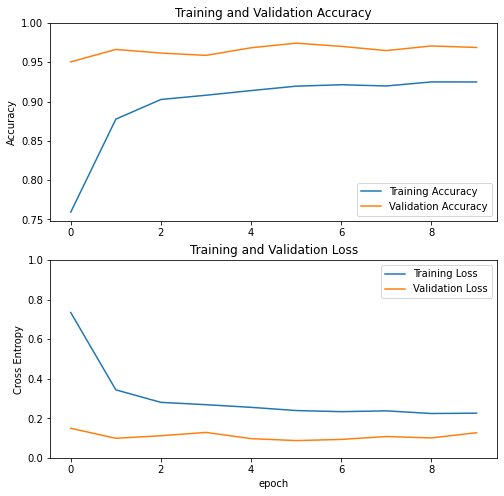

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 1, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 26)                858       
Total params: 2,627,514
Trainable params: 2,232,122
Non-trainable params: 395,392
_________________________________________________________________


In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 60


In [ ]:
history_fine = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=10, 
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))

Epoch 1/10
596/596 [==============================] - 575s 965ms/step - loss: 4.2088 - accuracy: 0.6175 - val_loss: 0.2657 - val_accuracy: 0.9260
Epoch 2/10
596/596 [==============================] - 575s 964ms/step - loss: 0.6854 - accuracy: 0.8172 - val_loss: 0.3155 - val_accuracy: 0.9155
Epoch 3/10
596/596 [==============================] - 573s 961ms/step - loss: 0.4178 - accuracy: 0.8692 - val_loss: 0.2787 - val_accuracy: 0.9274
Epoch 4/10
596/596 [==============================] - 575s 964ms/step - loss: 0.2980 - accuracy: 0.9022 - val_loss: 0.2414 - val_accuracy: 0.9413
Epoch 5/10
596/596 [==============================] - 577s 969ms/step - loss: 0.2442 - accuracy: 0.9188 - val_loss: 0.2212 - val_accuracy: 0.9481
Epoch 6/10
596/596 [==============================] - 572s 960ms/step - loss: 0.1998 - accuracy: 0.9332 - val_loss: 0.1955 - val_accuracy: 0.9525
Epoch 7/10
596/596 [==============================] - 575s 965ms/step - loss: 0.1743 - accuracy: 0.9410 - val_loss: 0.1834 -

In [ ]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/fine_tuning/assets


In [ ]:
from google.colab import files

files.download('model.tflite')
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

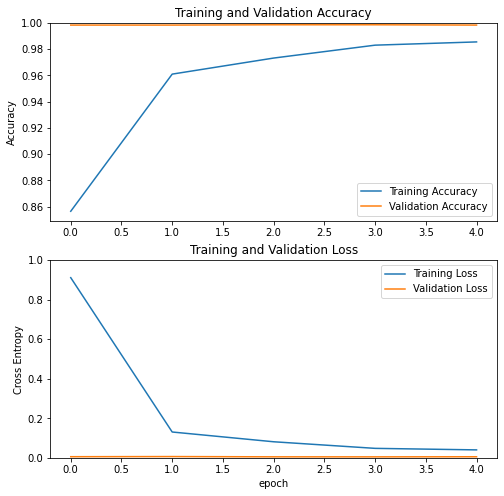

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# New section